In [1]:
!pip3 install -q tensorflow
!pip3 install -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.4 MB/s eta 0:00:00a 0:00:01


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras

2024-01-21 22:37:19.388963: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-21 22:37:19.542530: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-21 22:37:19.543633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-21 22:37:20.221993: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ds_train = pd.read_csv('./data/fashion-mnist_train.csv')
ds_test = pd.read_csv('./data/fashion-mnist_test.csv')
ds_train.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data Prep

In [3]:
# Extracting images and labels
train_images = ds_train.iloc[:, 1:].values.reshape(-1, 28, 28, 1)
train_labels = ds_train.iloc[:, 0].values

test_images = ds_test.iloc[:, 1:].values.reshape(-1, 28, 28, 1)
test_labels = ds_test.iloc[:, 0].values

# Normalizing pixel values to the range [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

## Convolutional Network

Convolutional Network makes a grid like thing on top of our image

<br />
<img src="./assets/conv-network.jpeg" />
<br />

In [9]:
# reduce size of input image before we start "convoluting" on it
model = keras.Sequential([
    keras.layers.AveragePooling2D(pool_size=(6,6), strides=3, input_shape=(28,28,1)), # on 28x28 image we put boxes averaging box squares 6x6 pixels => image after this layer is 100x100
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPool2D(2,2), # from each box 2x2 we take just max value
    keras.layers.Dropout(0.5), # drop 50% of connections
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax') # Because we have 10 classes
])

model.compile(
    optimizer='adam',
    # loss=keras.losses.SparseCategoricalCrossentropy(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [10]:
model.fit(train_images, train_labels, epochs=5, batch_size=32)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.8885 - accuracy: 0.6658
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6780 - accuracy: 0.7497
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6239 - accuracy: 0.7698
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5861 - accuracy: 0.7829
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5576 - accuracy: 0.7923


In [11]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 0s 947us/step - loss: 0.4747 - accuracy: 0.8184


[0.47466498613357544, 0.8184000253677368]

## Hyperparameter Tuning

In [12]:
from kerastuner.tuners import RandomSearch

"""
  It's exactly the same base for the model we had earlier but using builer design patter.
  hp - hyper-parameter
  hp.Choice("Layer type/label", [ list of params we would like to consider ])
  same layers don't depend on params so we can simple hardcode the model.add( ... )
"""
def build_model(hp):
    model = keras.Sequential()

    model.add(keras.layers.AveragePooling2D(6, 3, input_shape=(28, 28, 1)))

    for i in range(hp.Int("Conv Layers", min_value=0, max_value=10)):
        filters = hp.Choice(f"layer_{i}_filters", [16, 32, 64])
        kernel_size = (3, 3)

        if model.output_shape[1] >= kernel_size[0] and model.output_shape[2] >= kernel_size[1]:
            model.add(keras.layers.Conv2D(filters, kernel_size, activation='relu'))
        else:
            break  # Stop adding Conv2D layers if dimensions become invalid

    model.add(keras.layers.MaxPool2D(2, 2))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(hp.Choice("Dense layer", [64, 128, 256, 512, 1024]), activation='relu'))

    model.add(keras.layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    directory='./data/model/tuning',
    max_trials=32,
)

Reloading Tuner from ./data/model/tuning/untitled_project/tuner0.json


In [13]:
tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=32)

Trial 32 Complete [00h 00m 18s]
val_accuracy: 0.545199990272522

Best val_accuracy So Far: 0.866599977016449
Total elapsed time: 00h 23m 26s


In [14]:
# Out of all tried models get the best one
best_model = tuner.get_best_models()[0]

In [15]:
# Check how the best model is doing
best_model.evaluate(test_images, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.3548 - accuracy: 0.8666


[0.3547852039337158, 0.866599977016449]

## Exporting And Importing model

In [16]:
best_model.save('./data/models/nn_model')

INFO:tensorflow:Assets written to: ./data/models/nn_model/assets


INFO:tensorflow:Assets written to: ./data/models/nn_model/assets


## Use Model to Predict Result for Single Example

In [17]:
result = best_model.predict(np.array([train_images[0]]))
print(result)

predicted_value = np.argmax(result)
print(predicted_value)

1/1 [==============================] - 0s 47ms/step
[[9.3545362e-02 1.2320996e-03 2.0911427e-01 4.8915196e-02 3.0934241e-01
  9.4632407e-05 2.7144903e-01 5.0226216e-05 6.6246592e-02 1.0205282e-05]]
4


## Basic Embedding analysis

In [18]:
model_without_last_layer = keras.Sequential(best_model.layers[:-1])
embeddings = model_without_last_layer.predict(train_images)

1875/1875 [==============================] - 2s 966us/step


### T-SNE dimensions reduction - 3D 

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=3, random_state=42, n_jobs=-1)
embeddings_3d = tsne.fit_transform(embeddings)

In [22]:
data_embedded = pd.DataFrame(embeddings_3d, columns=["T1", "T2", "T3"])
data_embedded["type"] = train_labels
data_embedded.head()

,T1,T2,T3,type
0,-4.290965,-10.863806,8.099401,2
1,3.770379,0.378175,-1.065039,9
2,-13.870101,-16.424587,-3.869523,6
3,-12.398582,18.340500,-18.268093,0
4,-27.123764,7.587726,-4.617449,3


In [23]:
class_labels_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

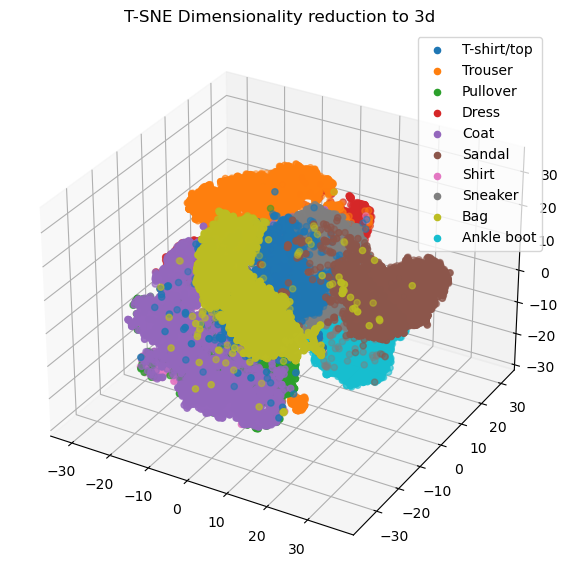

In [24]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')

groups = data_embedded.groupby("type")
for name, group in groups:
    ax.scatter(group["T1"], group["T2"], group["T3"], marker="o", label=class_labels_mapping[name])
ax.legend()
t=ax.set_title("T-SNE Dimensionality reduction to 3d")

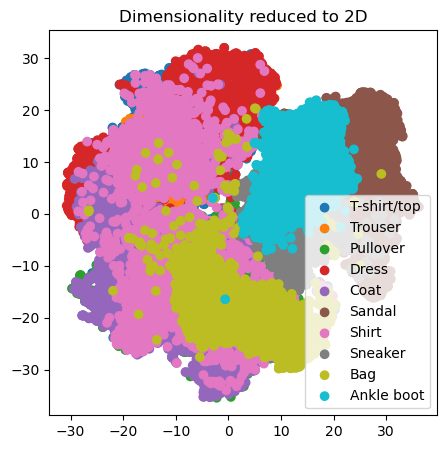

In [25]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

groups = data_embedded.groupby("type")
for name, group in groups:
    ax.scatter(group["T1"], group["T2"], marker="o", linestyle="", label=class_labels_mapping[name])
ax.legend()
t = ax.set_title("Dimensionality reduced to 2D")

In [26]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42, n_init="auto").fit(data_embedded)
km_labels = kmeans.labels_

km_df = pd.DataFrame({'Cluster_Labels': km_labels})
result_df_with_clusters = pd.concat([data_embedded, km_df], axis=1)

result_df_with_clusters.head()

,T1,T2,T3,type,Cluster_Labels
0,-4.290965,-10.863806,8.099401,2,8
1,3.770379,0.378175,-1.065039,9,3
2,-13.870101,-16.424587,-3.869523,6,5
3,-12.398582,18.340500,-18.268093,0,0
4,-27.123764,7.587726,-4.617449,3,5


In [28]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score_value = adjusted_rand_score(train_labels, km_labels)
print(f"Adjusted Rand Score: {adjusted_rand_score_value}")

Adjusted Rand Score: 0.5425959887149799


In [30]:
def label_str(label_value):
    clothing_classes = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
    return clothing_classes.get(label_value, str(label_value))

grouped_by_cluster = result_df_with_clusters.groupby("Cluster_Labels")
class_counts_by_cluster = grouped_by_cluster["type"].value_counts()
class_counts_by_cluster

Cluster_Labels  type
0               0       4752
                6       1332
                3        194
                2         47
                4         14
                        ... 
9               7        358
                9         75
                8         11
                0          2
                2          2
Name: count, Length: 78, dtype: int64

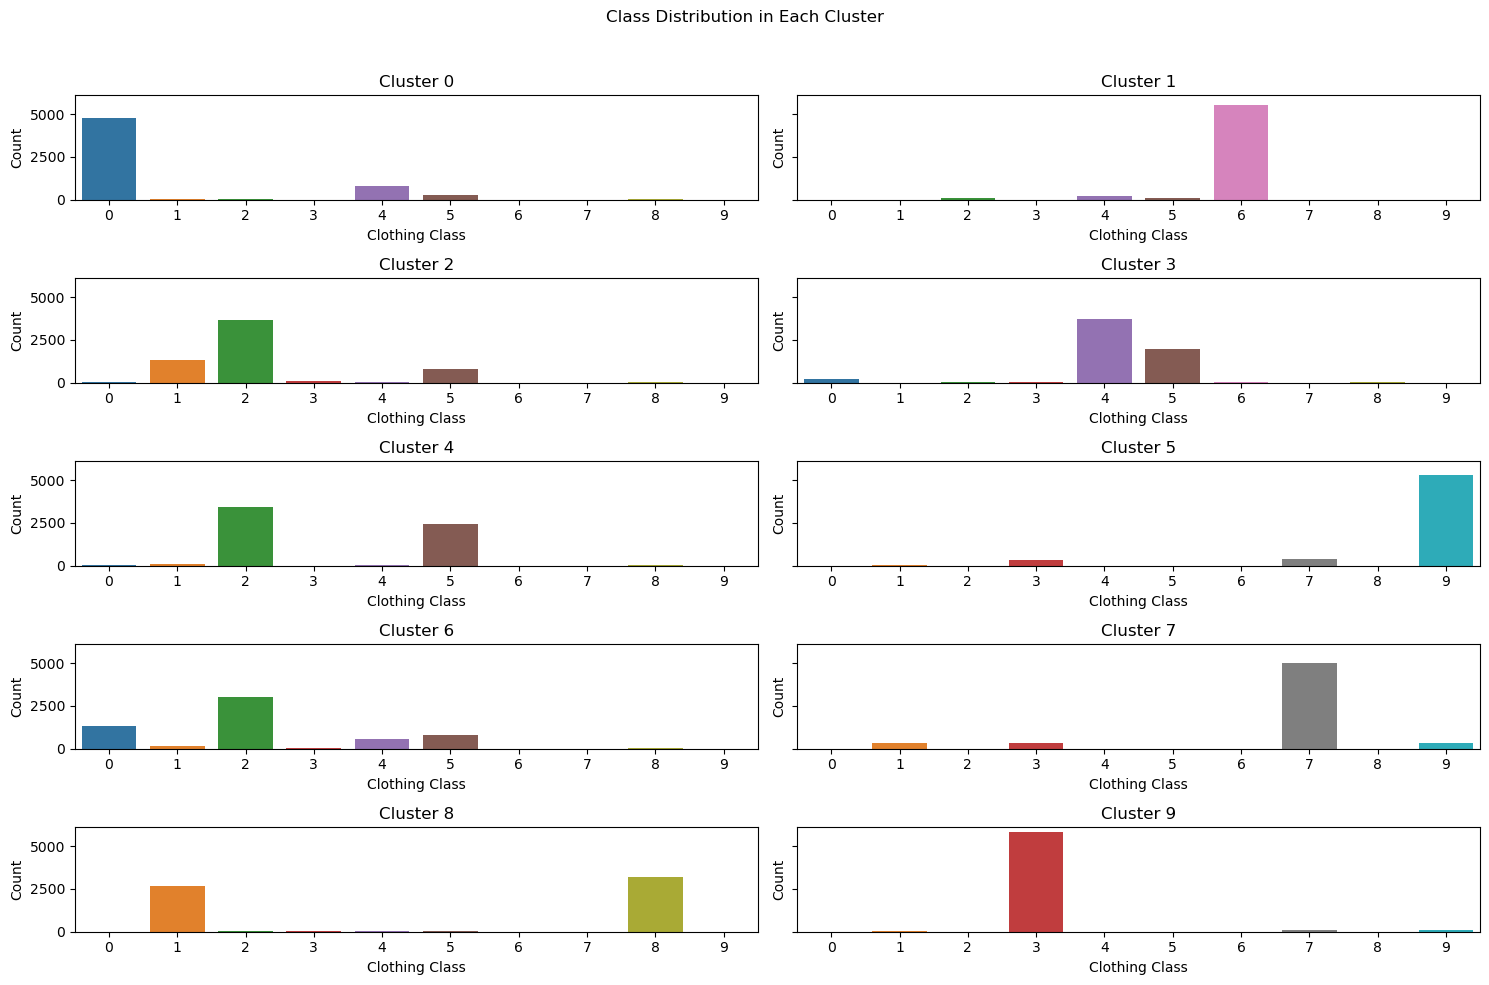

In [31]:
import seaborn as sns

class_counts_df = class_counts_by_cluster.unstack()

fig, axs = plt.subplots(5, 2, sharey=True, figsize=(15, 10))
fig.suptitle('Class Distribution in Each Cluster')

for cluster_label, ax in zip(class_counts_df.columns, axs.flatten()):
    cluster_data = class_counts_df[cluster_label].sort_index()

    sns.barplot(x=cluster_data.index, y=cluster_data.values, ax=ax)
    ax.set_title(f'Cluster {cluster_label}')
    ax.set_xlabel('Clothing Class')
    ax.set_ylabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

## Printing Embeddings

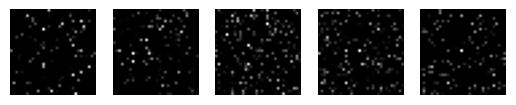

In [37]:
num_display = 5
for i in range(num_display):
    plt.subplot(1, num_display, i + 1)
    plt.imshow(embeddings[i].reshape((32, 32)), cmap='gray') 
    plt.axis('off')

plt.show()